# Satellite Spatio-Temporal NO2 Data

Here I collected in a dataframe calculated statistics related to  different air quality temporal signals for different locations
from:
  
    OMANO2
    https://disc.gsfc.nasa.gov/datasets/OMNO2d_003/summary?keywords=ColumnAmountNO2
    
    data
    https://acdisc.gsfc.nasa.gov/data/Aura_OMI_Level3//OMNO2d.003/2020/
    

# Library

In [3]:
import numpy as np 
import h5py 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd

from os import listdir
from os.path import isfile, join
import os 
import seaborn as sns


# this get all file froma a directory 
def get_files(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and not f.startswith(".")]
    return sorted(onlyfiles)


def get_stats(data_info, signal, datafiles, index=None, stat=np.mean):
    #FILE_NAME = ppp
    #DATAFIELD_NAME = '/HDFEOS/GRIDS/OMI Total Column Amount SO2/Data Fields/SlantColumnAmountSO2'
    #loc = location_range_italy
    #fig = plt.figure(figsize=[15,15])

    DATAFIELD_NAME = data_info['datafield']+ "/" +signal["name"]
    out =[]
    for d in datafiles:
        FILE_NAME = os.path.join(data_info['path'], d)
        with h5py.File(FILE_NAME, mode='r') as f:
            # List available datasets.
            #print(f.keys())

            # Read dataset.
            dset = f[DATAFIELD_NAME]
            data = dset[:]
            #denom = np.meadian(data) 
            
            shape = data.shape
            
            
            if index is None:
                out.append(stat(data))
            else:
                out.append(stat(data[index]))
            
    return out

def get_timestamp2(file_name):
    '''
    this read the first data from the following format
    'OMI-Aura_L3-OMNO2d_2020m0104_v003-2020m0330t173631.he5'
    part_num =2 reads the first data from the left 
    part_num = 3 reads teh first data from the right
    '''
    part_num = 2
    sp = file_name.split("-")[part_num]
    date = sp
    if sp.find('_')!=-1:
        date = sp.split("_")[1]
        
    YYYY = date[0:date.rfind('m')]
    MM = date[date.rfind('m')+1:date.rfind('m')+3]
    DD = date[date.rfind('m')+3:date.rfind('m')+5]
    
    hh = '-1'
    mm = '-1'
    ss = '-1'
    if date.rfind('t')!=-1:
        hh = date[date.rfind('t')+1:][0:2]
        mm = date[date.rfind('t')+1:][2:4]
        ss = date[date.rfind('t')+1:][4:6]
    return YYYY,MM,DD,hh,mm, ss


def show_map(FILE_NAME, DATAFIELD_NAME, loc):
# Open file.

    fig = plt.figure(figsize=[15,15])
    with h5py.File(FILE_NAME, mode='r') as f:
        # List available datasets.
        print(f.keys())

        # Read dataset.
        dset = f[DATAFIELD_NAME]
        data = dset[:]

        data = data[data!=-1.2676506E30]
        # Handle fill value.
        #data[data == dset.fillvalue] = np.nan
        #data = np.ma.masked_where(np.isnan(data), data)

        # Get attributes needed for the plot.
        # String attributes actually come in as the bytes type and should
        # be decoded to UTF-8 (python3).
        title = dset.attrs['Title'].decode()
        units = dset.attrs['Units'].decode()

        longitude = np.arange(0., 1440.0) * 0.25 - 180 + 0.125
        latitude = np.arange(0., 720.0) * 0.25 - 90 + 0.125

        #m = Basemap(projection='cyl', resolution='l', llcrnrlat=-90, urcrnrlat = 90, llcrnrlon=-180, urcrnrlon = 180)
        m = Basemap(projection='cyl', 
                    resolution='l', 
                    llcrnrlat=loc["llcrnrlat"], 
                    urcrnrlat = loc["urcrnrlat"], 
                    llcrnrlon=loc["llcrnrlon"], 
                    urcrnrlon = loc["urcrnrlon"])

        m.drawcoastlines(linewidth=3)
        m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])
        #x, y = m(longitude, latitude,)


        aaa = m.pcolormesh(longitude, latitude, data, latlon=True)
        cb = m.colorbar()
        cb.set_label(units)
        
# extract froom filename the timestamp
def get_timestamp(file_name):
    date = file_name[file_name.rfind('-')+1:file_name.rfind('.')]
    YYYY = date[0:date.rfind('m')]
    MM = date[date.rfind('m')+1:date.rfind('t')][0:2]
    DD = date[date.rfind('m')+1:date.rfind('t')][2:4]
    hh = date[date.rfind('t')+1:][0:2]
    mm = date[date.rfind('t')+1:][2:4]
    ss = date[date.rfind('t')+1:][4:6]
    return YYYY,MM,DD,hh,mm, ss


def xy(angle_lat, angle_lon):
    y = (-1)* 720 * angle_lon/ (-180)
    x = (-1) * 1440 * angle_lat/ (-360)
    
    if y >720: y=720
    if x >1440: x=1440

    return np.int16(np.round(x)), np.int16(np.round(y))


class storage():

    def __init__(self):

        #self.location = location
       
        #self.filename = filename
        #self.schema ={'date': '', 
        #              'hashtag': '', 
        #              'username': ''}
        '''
        self.schema = {'product_shortname': '', \
                       "signal_name":'',\
                       'value': '',\
                      'year': '',\
                      'month': '',\
                      'day': '', \
                      'hour': '', \
                      'minutes': '', \
                      'seconds':'', \
                      }
        '''
        
        self.schema = ['product_name',
                        'signal_name',
                        'loc_name',
                        'loc_lat',
                        'loc_lang',
                        'loc_zoom',
                        'value_mn',
                        'value_sd',
                        'value_md',
                        'value_q1',
                        'value_q2',
                        'year',
                        'month',
                        'day', 
                        'hour', 
                        'minutes', 
                        'seconds'
                        ]
        self.df = None

        #self.load()

        if self.df is None: self.new()

    def new(self): 
        self.df = pd.DataFrame(columns=self.schema)
        return self.df

    def load(self, location, filename, verbose=False):

        spath = location + '/' + filename

        if not os.path.isfile(spath):
            if verbose:
                print('Error: file not found:', spath)
            return -1

        self.df = pd.read_csv(spath, index_col=False)
        return 0

    def show(self): self.df.head()

    def schema(self): return schema

    def add(self, rowdic):
        try:
            #print(rowdic)
            self.df = self.df.append(rowdic, ignore_index=True)
            # return self.df

        except Exception() as e:
            print('Error:', e, '\n Schema:', self.schema)
            # return None

    def save(self, location, filename):
        spath = location

        if not os.path.exists(spath):
            os.makedirs(spath)

        spath = spath + '/' + filename
       
        if not os.path.isfile(spath):
            self.df.to_csv(spath, header=self.schema, index=False, columns=self.schema)
        else:  # else it exists so append without writing the header
            self.df.to_csv(spath, mode='w', header=True, index=False, columns=self.schema)
  
    def concat(self, storage2):
        self.df = pd.concat([self.df, storage2.df], ignore_index=True)


def rescale_column(df_in, colname_togroup, colname_torescale, colname_new):
    df_temp = df_in[df_in[colname_torescale]>0]
    max_v = df_temp.filter([colname_togroup, colname_torescale]).groupby([colname_togroup]).max()
    min_v = df_temp.filter([colname_togroup, colname_torescale]).groupby([colname_togroup]).min()
    
    df = df_in.copy()
    df[colname_new]=df[colname_torescale]
    for i in range(max_v.shape[0]):
        group_name = max_v.iloc[i].name
        min_val = min_v.iloc[i].value_mn
        max_val = max_v.iloc[i].value_mn
        
        df.loc[df[colname_togroup]==group_name, colname_new]-=min_val
        df.loc[df[colname_togroup]==group_name, colname_new]/=max_val
        
    return df


def create_dataframe(data_info, signal, locations, units="DU", 
                     minv = None, maxv=None, min_percdata_forstats=0.8,
                    messages_out = False):
    #FILE_NAME = ppp
    #DATAFIELD_NAME = '/HDFEOS/GRIDS/OMI Total Column Amount SO2/Data Fields/SlantColumnAmountSO2'
    #loc = location_range_italy
    #fig = plt.figure(figsize=[15,15])
    st = storage()
    
    allfiles = get_files(data_info['path'])
    
    DATAFIELD_NAME = data_info['datafield']+ "/" +signal["name"]
    out =[]
    
    for file_name in allfiles:
        
        
        FILE_NAME = os.path.join(data_info['path'], file_name)
        with h5py.File(FILE_NAME, mode='r') as f:
            # List available datasets.
            #print(f.keys())

            # Read dataset.
            dset = f[DATAFIELD_NAME]
            data = dset[:]
            
            '''    
            if units =="DU":
                DU = 2.6867*10**16
                data_filtered = data/DU 

            if minv is not None:
                data_filtered[data_filtered<minv]=np.NaN
            if maxv is not None:
                data_filtered[data_filtered>maxv]=np.NaN
            '''
            
            # extract time from the file name
            YYYY,MM,DD,hh,mm, ss = get_timestamp2(file_name)
            
            for location in locations:
                
                stats = get_location_stats(location, data, 
                                           units="DU" , minv=minv, maxv=maxv, 
                                           min_percdata_forstats=min_percdata_forstats,
                                           messages_out=messages_out)
                
                mn = stats[0]
                sd = stats[1]
                md = stats[2]
                q1 = stats[3]
                q2 = stats[4]
                if np.isnan(mn):
                    if messages_out:
                        print("location: {} file: {}".format(location["name"], file_name) )
                
                row = {'product_name': data_info['shortname'],
                        "signal_name": signal["name"],
                        'loc_name': location["name"],
                        'loc_lat': location["lat"],
                        'loc_lang': location["long"],
                        'loc_zoom': location["zoom"],
                        'value_mn': stats[0],
                        'value_sd': stats[1],
                        'value_md': stats[2],
                        'value_q1': stats[3],
                        'value_q2': stats[4],
                        'year': YYYY,
                        'month': MM,
                        'day': DD, 
                        'hour': hh, 
                        'minutes': mm, 
                        'seconds':ss
                        }
                
                st.add(row)
            
            
            '''
            shape = data.shape
            if len(shape)==4: #nwave
                for i in range(signal["nwave"]):
                    data_nwave = data[:,i,:,:]
                    data_nwave = data_nwave.reshape([data_nwave.shape[0]*data_nwave.shape[1]*data_nwave.shape[2]])
                    stat_val = stat(data_nwave[data_nwave!=signal['missing_value']])
                    row['signal_name']= signal["name"]+"_nwave_" +str(i)
                    row['value']= stat_val
                    st.add(row)
                    
            if len(shape)==3:
                data = data.reshape([data.shape[0]*data.shape[1]*data.shape[2]])
                stat_val = stat(data[data!=signal['missing_value']])
                row['value']= stat_val
                st.add(row)
                
            if len(shape)==2:
                data = data.reshape([data.shape[0]*data.shape[1]])
                stat_val = stat(data[data!=signal['missing_value']])
                row['value']= stat_val
                st.add(row)
            '''
            
    st.df.sort_values(by=['year', 'month', 'day', 'hour', 'minutes', 'seconds'],inplace=True)
    
    # Rescale
    st.df = rescale_column(st.df, "loc_name", "value_mn","value_mn_rescale")
    
    return st


def get_location_stats(location, data, zoom = 1, \
                       units="DU" , minv=None, maxv=None, min_percdata_forstats=0.9, \
                       show_map=False, show_stats=False, \
                       figsize = [7,7],
                      messages_out = False):
    '''
    location = info about location, ex. format = {"lat":39, "long" :116, "zoom":5}
    data = 2d array (lat x long) of satellite signals
    units = DU of molcm2, 1 DU = 2.6867*10**16 mol/cm2
    min_percdata_forstats= is the minumu perc of data to produce statistic. satellites can have dark zones
    
    '''
    longitude = np.arange(0., 1440.0) * 0.25 - 180 + 0.125
    latitude = np.arange(0., 720.0) * 0.25 - 90 + 0.125
    
    if zoom is None:
        zoom = location['zoom']
        
    X = np.argwhere((latitude>location["lat"]-zoom) & (latitude<=location["lat"]+zoom)).flatten()
    Y = np.argwhere((longitude>location["long"]-zoom) & (longitude<=location["long"]+zoom)).flatten()
    data_filtered = data[X,:]
    data_filtered = data_filtered[:,Y]
    
    if units =="DU":
        DU = 2.6867*10**16
        data_filtered = data_filtered/DU 
        
    if minv is not None:
        data_filtered[data_filtered<minv]=np.NaN
    if maxv is not None:
        data_filtered[data_filtered>maxv]=np.NaN

    if show_map ==True:
        plt.figure(figsize=figsize)
        plt.imshow(data_filtered, cmap="Paired", vmin=minv, vmax=maxv)
        plt.show()
    if show_stats == True:
        d = [ i for i in data_filtered.flatten()  if i >0 ]
        bp = sns.boxplot(d)
        sns.stripplot(d, color="orange", jitter=0.2, size=2.5,)

        #plt.show()
    
    # if num nan is > than 90% return Nan (it means that the satellite was not covering the area)
    num_nan = data_filtered[np.isnan(data_filtered)].shape[0]
    n = data_filtered.flatten().shape[0]
    if (num_nan/n)>=min_percdata_forstats:
        if messages_out:
            print("Statistics are not returned when the number of nan values in the data is > {}%".format(min_percdata_forstats *100) )
        return -1,-1,-1,-1,-1
    
    if messages_out: 
        print("percentage of Null values:", num_nan/n, num_nan, n)
    
    Q1 = np.nanpercentile(data_filtered, 25)
    MD = np.nanpercentile(data_filtered, 50)
    Q2 = np.nanpercentile(data_filtered, 75)
    SD = np.nanstd(data_filtered)
    MN = np.nanmean(data_filtered)
    
    return MN, SD, MD, Q1, Q2


def get_missing_Value(datadescr, signal):
    
    datafiles = get_files(datadescr['path'])
    f0 = h5py.File(os.path.join(datadescr['path'], datafiles[0]),"r")

    dd= f0[datadescr['datafield']+"/"+signal['name']]
    dd = np.array(dd)
    n = len(dd.shape)
    if n==4:
        ddd = dd.reshape([dd.shape[0]*dd.shape[1]*dd.shape[2]*dd.shape[3]])
    if n==3:
        ddd = dd.reshape([dd.shape[0]*dd.shape[1]*dd.shape[2]])
    if n==2:
        ddd = dd.reshape([dd.shape[0]*dd.shape[1]])
    
    return np.min(ddd)


def show_map(FILE_NAME, DATAFIELD_NAME, loc, Colormap = "viridis", minv=None, maxv=None, zoom=1):
# Open file.

    fig = plt.figure(figsize=[8,8])
    with h5py.File(FILE_NAME, mode='r') as f:
        # List available datasets.
        print(f.keys())

        # Read dataset.
        dset = f[DATAFIELD_NAME]
        data = dset[:]

        DU_1 = 2.6867*10**16
        data = data/DU_1
        units = "DU"
        
        if minv is not None:
            data[data<minv] =np.NaN
        
        if maxv is not None:
            data[data>maxv] =np.NaN
            
        # Get attributes needed for the plot.
        # String attributes actually come in as the bytes type and should
        # be decoded to UTF-8 (python3).
        title = dset.attrs['Title'].decode()
        units = dset.attrs['Units'].decode()
        
       
        
        longitude = np.arange(0., 1440.0) * 0.25 - 180 + 0.125
        latitude = np.arange(0., 720.0) * 0.25 - 90 + 0.125

        #m = Basemap(projection='cyl', resolution='l', llcrnrlat=-90, urcrnrlat = 90, llcrnrlon=-180, urcrnrlon = 180)
        
        llcrnrlat = loc['lat'] -zoom
        urcrnrlat = loc['lat'] +zoom
        llcrnrlon = loc['long'] -zoom 
        urcrnrlon = loc['long'] +zoom 
        
        m = Basemap(width=1200000,height=900000,
                    projection='cyl', 
                    resolution='l', 
                    llcrnrlat=llcrnrlat, 
                    urcrnrlat = urcrnrlat, 
                    llcrnrlon=llcrnrlon, 
                    urcrnrlon = urcrnrlon)
        
        
        m.drawcoastlines(linewidth=1)
        m.drawparallels(np.arange(-90., 120., 3.), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180., 181., 6.), labels=[0, 0, 0, 1])
        #x, y = m(longitude, latitude,)
        
      
            
        aaa = m.pcolormesh(longitude, latitude, data, latlon=True, cmap=Colormap, vmin=minv, vmax=maxv)
        cb = m.colorbar()
        
        cb.set_label(units)
        
# this get all file froma a directory 
def get_files(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and not f.startswith(".")]
    return sorted(onlyfiles)

def xy(angle_lat, angle_lon):
    y = (-1)* 720 * angle_lon/ (-180)
    x = (-1) * 1440 * angle_lat/ (-360)
    
    if y >720: y=720
    if x >1440: x=1440

    return np.int16(np.round(x)), np.int16(np.round(y))

# Data

### Data info structures

In [55]:
datadesc_OMNO2 = {"shortname":"OMNO2",
                    "path":"./data/OMNO2d.003/2020b/", 
                    "datafield":"/HDFEOS/GRIDS/ColumnAmountNO2/Data Fields"}

signal_ColumnAmountNO2TropCloudScreened = {"name":"ColumnAmountNO2TropCloudScreened",
                                           "missing_value":-1.2676506e+30}

loc_italy = {"name":"italy", "lat":41.8, "long" :12.8, "zoom":5}
loc_milan = {"name":"milan", "lat":45.5, "long" :9.1, "zoom":1}
loc_boston = {"name":"boston", "lat":42.3, "long" :-71, "zoom":5}
loc_beijin = {"name":"beijin", "lat":39, "long" :116, "zoom":5}
loc_manaus = {"name":"manaus", "lat":-3, "long" :-60, "zoom":5}
loc_sanpaolo= {"name":"sanpaolo", "lat":-24, "long" :-47, "zoom":5}
loc_sydney= {"name":"sydney", "lat":-34, "long" :151, "zoom":5}
loc_artic= {"name":"artic", "lat":76, "long" :-100, "zoom":5}
loc_linfen= {"name":"linfen", "lat":36, "long" :112, "zoom":3}
loc_sukinda= {"name":"sukinda", "lat":30, "long" :78, "zoom":3}
loc_linares= {"name":"linares", "lat":-36, "long" :-72, "zoom":3}
loc_wuham= {"name":"wuham", "lat":38, "long" :115, "zoom":3}
loc_newyork= {"name":"newyork", "lat":42, "long" :-74, "zoom":2}
loc_brussel= {"name":"brussel", "lat":47, "long" :20, "zoom":5}
loc_atlanta= {"name":"atlanta", "lat":34, "long" :-83.9, "zoom":2}
loc_chicago= {"name":"chicago", "lat":42, "long" :-87, "zoom":2}
loc_Baghjan= {"name":"Baghjan", "lat":24, "long" :90, "zoom":2}
loc_Norilsk= {"name":"Norilsk", "lat":69, "long" :88, "zoom":5}
locations = [loc_milan, loc_wuham]

### Create Dataframe

In [56]:

s1 = create_dataframe(datadesc_OMNO2, 
                 signal_ColumnAmountNO2TropCloudScreened, 
                 locations, 
                 units="DU", minv = 0.05, maxv=1,
                 min_percdata_forstats=0.85,
                 messages_out = False)
    
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:393: RuntimeWarning: invalid value encountered in greater


In [77]:
#s1.save("/Users/rempicon/Google_Drive/MYCODE/PRJ/GIT/SpaceAppsCOVIDChallenge/data", "OMNO2d003_2020_v6.csv")

In [6]:
s1.df.to_csv("/Users/rempicon/Google_Drive/MYCODE/PRJ/GIT/SpaceAppsCOVIDChallenge/data/OMNO2d003_2020_01_06_milan_wuhan.csv")


In [65]:
s1.df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,550,551,552,553,554,555,556,557,558,559
product_name,OMNO2,OMNO2,OMNO2,OMNO2,OMNO2,OMNO2,OMNO2,OMNO2,OMNO2,OMNO2,...,OMNO2,OMNO2,OMNO2,OMNO2,OMNO2,OMNO2,OMNO2,OMNO2,OMNO2,OMNO2
signal_name,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,...,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened,ColumnAmountNO2TropCloudScreened
loc_name,milan,wuham,milan,wuham,milan,wuham,milan,wuham,milan,wuham,...,milan,wuham,milan,wuham,milan,wuham,milan,wuham,milan,wuham
loc_lat,45.5,38,45.5,38,45.5,38,45.5,38,45.5,38,...,45.5,38,45.5,38,45.5,38,45.5,38,45.5,38
loc_lang,9.1,115,9.1,115,9.1,115,9.1,115,9.1,115,...,9.1,115,9.1,115,9.1,115,9.1,115,9.1,115
loc_zoom,1,3,1,3,1,3,1,3,1,3,...,1,3,1,3,1,3,1,3,1,3
value_mn,0.298904,-1,0.327142,-1,0.309057,-1,-1,-1,-1,-1,...,-1,0.259049,0.105916,0.298674,-1,-1,-1,0.30634,0.174557,-1
value_sd,0.19587,-1,0.122615,-1,0.112301,-1,-1,-1,-1,-1,...,-1,0.089239,0.0409707,0.0719678,-1,-1,-1,0.0846638,0.0955677,-1
value_md,0.247546,-1,0.363132,-1,0.359892,-1,-1,-1,-1,-1,...,-1,0.27486,0.0897418,0.308322,-1,-1,-1,0.322636,0.12836,-1
value_q1,0.164572,-1,0.282458,-1,0.267211,-1,-1,-1,-1,-1,...,-1,0.195152,0.0764871,0.256594,-1,-1,-1,0.256854,0.0982148,-1


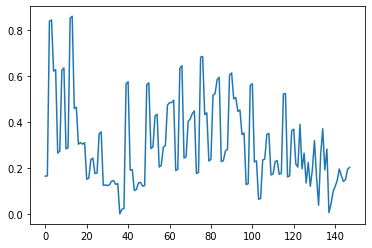

In [59]:
df1 = s1.df
df2 = df1[df1.loc_name == "wuham"]
df3 = df1[df1.loc_name == "milan"]


a = np.array(df2.value_mn_rescale)
plt.plot(a[a>0])
#a = np.array(df3.value_mn_rescale)
#plt.plot(a[a>0])


NameError: name 'df4' is not defined

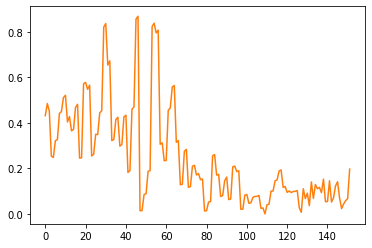

In [7]:
df1 = s1.df
df2 = df1[df1.loc_name == "wuham"]
df3 = df1[df1.loc_name == "milan"]
df4 = df1[df1.loc_name == "beijin"]
df5 = df1[df1.loc_name == "boston"]
df6 = df1[df1.loc_name == "atlanta"]
df7 = df1[df1.loc_name == "chicago"]

a = np.array(df2.value_mn_rescale)
plt.plot(a[a>0])
a = np.array(df3.value_mn_rescale)
plt.plot(a[a>0])
a = np.array(df4.value_mn_rescale)
plt.plot(a[a>-1])
a = np.array(df5.value_mn_rescale)
plt.plot(a[a>-1])
a = np.array(df6.value_mn_rescale)
plt.plot(a[a>-1])
a = np.array(df7.value_mn_rescale)
plt.plot(a[a>-1])

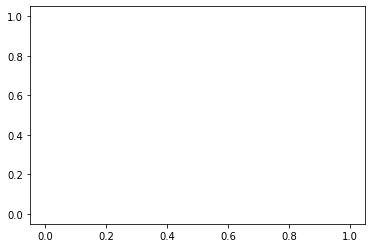

In [75]:
a = np.array(df7.value_mn_rescale)
plt.plot(a[a>-1])


# Show Locations and Stats

In [15]:
file_name

NameError: name 'file_name' is not defined

In [53]:
path = datadesc_OMNO2['path']
allfiles = get_files(path)
file_name = os.path.join(path, allfiles[112])
datafield = datadesc_OMNO2['datafield']
datafield_path = datafield+"/ColumnAmountNO2TropCloudScreened"

data_h5 = h5py.File(file_name,"r")
print(data_h5[datafield].keys())
data = data_h5[datafield_path]
data=np.array(data)

<KeysViewHDF5 ['ColumnAmountNO2', 'ColumnAmountNO2CloudScreened', 'ColumnAmountNO2Trop', 'ColumnAmountNO2TropCloudScreened', 'Weight']>


<KeysViewHDF5 ['HDFEOS', 'HDFEOS INFORMATION']>

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:464: RuntimeWarning: invalid value encountered in greater


<Figure size 1440x720 with 0 Axes>

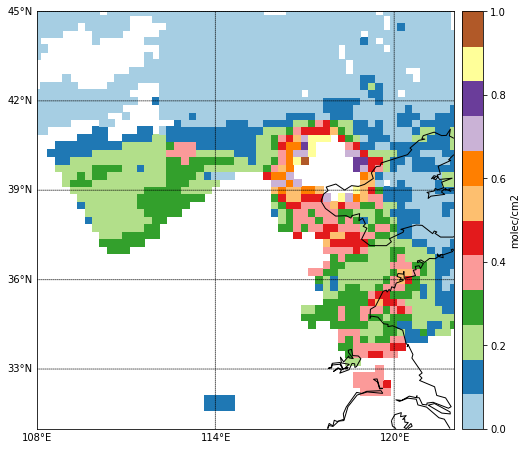

In [54]:
plt.figure(figsize=[20,10])

loc = loc_wuham
show_map(file_name, 
         datafield_path, 
         loc, 
         Colormap="Paired", 
         minv =0,
         maxv=1,
         zoom=7)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:393: RuntimeWarning: invalid value encountered in greater


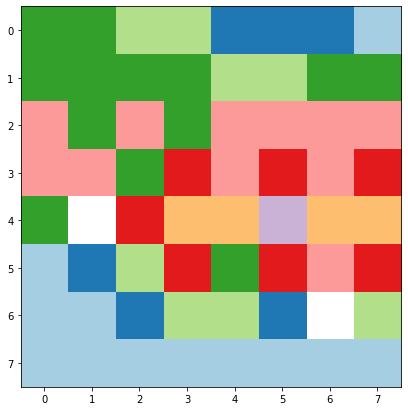

(0.26826563,
 0.16930136,
 0.30114971101284027,
 0.10287843085825443,
 0.37403546273708344)

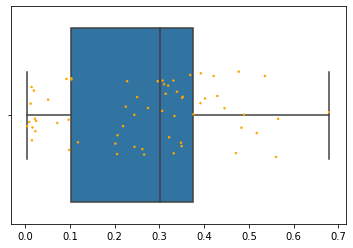

In [32]:
get_location_stats(loc,
                  data,
                  zoom=1,
                  minv=0,
                  maxv=1,
                  show_map=True, 
                  show_stats=True,
                  min_percdata_forstats=0.95)

In [176]:
f =  allfiles[3]
f

'OMI-Aura_L3-OMNO2d_2020m0104_v003-2020m0330t173631.he5'

In [200]:
# extract froom filename the timestamp
def get_timestamp2(file_name):
    '''
    this read the first data from the following format
    'OMI-Aura_L3-OMNO2d_2020m0104_v003-2020m0330t173631.he5'
    part_num =2 reads the first data from the left 
    part_num = 3 reads teh first data from the right
    '''
    part_num = 2
    sp = file_name.split("-")[part_num]
    print(sp)
    date = sp
    if sp.find('_')!=-1:
        date = sp.split("_")[1]
        
    YYYY = date[0:date.rfind('m')]
    MM = date[date.rfind('m')+1:date.rfind('m')+3]
    DD = date[date.rfind('m')+3:date.rfind('m')+5]
    
    hh = '-1'
    mm = '-1'
    ss = '-1'
    if date.rfind('t')!=-1:
        hh = date[date.rfind('t')+1:][0:2]
        mm = date[date.rfind('t')+1:][2:4]
        ss = date[date.rfind('t')+1:][4:6]
    return YYYY,MM,DD,hh,mm, ss



In [201]:
get_timestamp2(f)

2020m0330t173631.he5


('2020', '03', '30', '17', '36', '31')

In [188]:
"aaaa".rfind('e')

-1